In [1]:
import knoten
import knoten.csm as csm
import numpy as np
import gdal
from gdal import osr, ogr
import math, os
from string import Template
import matplotlib.pyplot as plt
import pyproj

In [2]:
class Dem:
    def __init__(self, filename):
        self.ds = gdal.Open(filename, gdal.GA_ReadOnly)
        srs = osr.SpatialReference()
        srs.ImportFromWkt(self.ds.GetProjection())
        srsLatLong = srs.CloneGeogCS()
        self.lat_lon_ct = osr.CoordinateTransformation(srsLatLong, srs)
        self.geoc_proj = pyproj.Proj(proj='geocent', a=srs.GetSemiMajor(), b=srs.GetSemiMinor())
        self.lat_lon_proj = pyproj.Proj(proj='latlon', a=srs.GetSemiMajor(), b=srs.GetSemiMinor())
        geomatrix = self.ds.GetGeoTransform()
        self.inv_geomatrix = gdal.InvGeoTransform(geomatrix)
    
    def get_lat_lon_elevation(self, longitude, latitude):
        (X, Y, height) = self.lat_lon_ct.TransformPoint(longitude, latitude)
        x = int(self.inv_geomatrix[0] + self.inv_geomatrix[1] * X + self.inv_geomatrix[2] * Y)
        y = int(self.inv_geomatrix[3] + self.inv_geomatrix[4] * X + self.inv_geomatrix[5] * Y)
        res = self.ds.ReadAsArray(x, y, 1, 1)
        return res[0][0]
    
    def get_rect_elevation(self, geoc_x, geoc_y, geoc_z):
        X, Y, height = pyproj.transform(self.geoc_proj, self.lat_lon_proj, geoc_x, geoc_y, geoc_z)
        x = int(self.inv_geomatrix[0] + self.inv_geomatrix[1] * X + self.inv_geomatrix[2] * Y)
        y = int(self.inv_geomatrix[3] + self.inv_geomatrix[4] * X + self.inv_geomatrix[5] * Y)
        res = self.ds.ReadAsArray(x, y, 1, 1)
        return res[0][0]

In [3]:
def compute_wms_range(cameras, dem_res, radius, pad = True):
    combined_footprints = ogr.Geometry(ogr.wkbPolygon)
    for camera in cameras:
        image_size = camera.getImageSize()
        pix_bound = knoten.csm.generate_boundary([image_size.line, image_size.samp])
        footprint = knoten.csm.generate_latlon_footprint(camera, pix_bound, radius, radius)
        combined_footprints = combined_footprints.Union(footprint)
    bounds = combined_footprints.GetEnvelope()
    if pad:
        bounds = (math.floor(bounds[0]), math.ceil(bounds[1]), math.floor(bounds[2]), math.ceil(bounds[3]))
    d_res = (dem_res / radius) * (180.0 / np.pi) # DEM resolution in degrees per pixel
    lon_range = bounds[1] - bounds[0]
    lat_range = bounds[3] - bounds[2]
    x_size = math.floor(lon_range / d_res)
    y_size = math.floor(lat_range / d_res)
    return bounds, (x_size, y_size)

In [4]:
def download_messenger_dem(bounds, size, xml_filename = "gdal_WMS.xml", filename = 'gdal_WMS.tif'):
    #build this XML file.
    # TODO use a jinja2 template
    gdal_XML = Template("""<GDAL_WMS>
      <Service name="WMS">
        <Version>1.1.1</Version>
        <ServerUrl>https://planetarymaps.usgs.gov/cgi-bin/mapserv?map=/maps/mercury/mercury_simp_cyl_elev.map</ServerUrl>
        <SRS>EPSG:4326</SRS>
        <ImageFormat>image/tiff</ImageFormat>
        <Layers>Messenger_elev</Layers>
      </Service>
      <DataWindow>
        <UpperLeftX>$minLon</UpperLeftX>
        <UpperLeftY>$maxLat</UpperLeftY>
        <LowerRightX>$maxLon</LowerRightX>
        <LowerRightY>$minLat</LowerRightY>
         <SizeX>$xSize</SizeX>
         <SizeY>$ySize</SizeY>
      </DataWindow>
      <Projection>EPSG:4326</Projection>
      <BandsCount>1</BandsCount>
      <DataType>Int16</DataType>
    </GDAL_WMS>
    """)

    gdal_WMS = gdal_XML.substitute(minLon=bounds[0], maxLon=bounds[1], minLat=bounds[2], maxLat=bounds[3], xSize=size[0], ySize=size[1])
    with open( xml_filename ,'w') as outFile:
        outFile.write( gdal_WMS  )
    
    wms_ds = gdal.Open(xml_filename)
    gdal.Translate(filename, wms_ds, outputSRS='GEOGCS["Mercury 2015",DATUM["D_Mercury_2015",SPHEROID["Mercury_2015_IAU",2440530.0,1075.123348017621]],PRIMEM["Reference_Meridian",0],UNIT["Degree",0.0174532925199433],AUTHORITY["IAU2015","19900"]]')

In [5]:
def intersect_dem(camera, dem, image_pt, tolerance = 1, max_its = 20):
    intersection = camera.imageToGround(image_pt, 0.0)
    iterations = 1
    converged = False
    while (not converged):
        height = dem.get_rect_elevation(intersection.x, intersection.y, intersection.z)
        next_intersection = camera.imageToGround(image_pt, float(height))
        dist = max(abs(intersection.x) - abs(next_intersection.x),
                   abs(intersection.y) - abs(next_intersection.y),
                   abs(intersection.z) - abs(next_intersection.z))
        intersection = next_intersection
        if dist < tolerance:
            converged = True
        iterations += 1
        if iterations > max_its:
            converged = True
    return intersection

In [6]:
image_dir = 'data'
EN0213023991M = os.path.join(image_dir, 'EN0213023991M.IMG')
EN0213110924M = os.path.join(image_dir, 'EN0213110924M.IMG')
dem = os.path.join(image_dir, 'example_mids_dem.tif')
wms_xml = os.path.join(image_dir, 'example_mids_wms.xml')

In [7]:
EN0213023991M_cam = knoten.csm.create_csm(EN0213023991M)
EN0213110924M_cam = knoten.csm.create_csm(EN0213110924M)

In [8]:
# Note MESSENGER DEM is 665 m/pix and MERCURY has a radius of 2439400 m
bounds, size = compute_wms_range([EN0213023991M_cam, EN0213110924M_cam], 665, 2439400)
download_messenger_dem(bounds, size = size, filename=dem, xml_filename=wms_xml)

In [9]:
print(bounds, size)

(-177, -173, 30, 33) (256, 192)


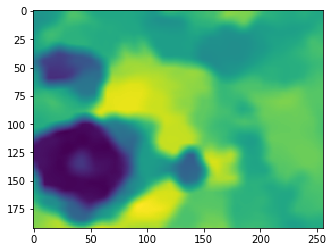

In [10]:
dem_ds = gdal.Open(dem)
plt.imshow(dem_ds.ReadAsArray())

In [11]:
test_dem = Dem(dem)

In [12]:
pt1 = EN0213023991M_cam.imageToGround(knoten.csmapi.ImageCoord(0,0), 0.0)
pt2 = EN0213023991M_cam.imageToGround(knoten.csmapi.ImageCoord(1,1), 0.0)
delta_x = pt1.x - pt2.x
delta_y = pt1.y - pt2.y
delta_z = pt1.z - pt2.z
ground_res = math.sqrt((delta_x*delta_x + delta_y*delta_y + delta_z*delta_z)/2)

In [13]:
dem_pt = intersect_dem(EN0213023991M_cam, test_dem, knoten.csmapi.ImageCoord(216, 216), tolerance=ground_res/100)
sphr_pt = EN0213023991M_cam.imageToGround(knoten.csmapi.ImageCoord(216, 216), 0.0)
print(dem_pt.x, dem_pt.y, dem_pt.z)
print(sphr_pt.x, sphr_pt.y, sphr_pt.z)

-2067695.5083646718 -158330.4073612832 1287561.040532591
-2066435.7005952501 -159381.98791860323 1286512.0431743076
